In [1]:
import pandas as pd
import requests
import json

## _This notebook is divided in to 4 main sections.
## 1. Preparing data - Downloading news articles.
## 2. Download Stock data and merging with new articles dataframe
## 3. Sentiment Analysis on News Articles and merging the results into main dataframe.
## 4. Regression Analysis to determine the correlation.

# Section1. Download news articles ---->

## Download news/articles and create a dataframe that will be used for sentiment and regression analysis later. Save the dataframe as .csv file


In [1]:
# Replace the keys below with actual values or load from ENV.
STOCK_NEWS_API_KEY="XXXXXXXX"
BREAKING_API_KEY="YYYYYYYYY"

In [3]:
# custom function to download articles for a particular ticker and save the dataframe as .csv.
## We needed to write this function because API DID NOT ALLOW the full set of article data to be returned in a single call. It allowed 50 items max in a call - &items=50
### We needed to pass ticker name and page number to get the specific page from response. We would save each page result as a csv file and merge them later to create a megadataframe
#### of all articles for the ticker (TSLA in our case).

def download_and_save_StockAPI_data(ticker, page):
    url="https://stocknewsapi.com/api/v1?tickers=" + ticker + "&date=01012019-12312019&items=50&page=" + page +"&token="+STOCK_NEWS_API
    outputfilename = "./data/stockenewsapi_pages/" + ticker + "_df_page" + page + ".csv"
    #print (url)
    api_result = requests.get(url)
    df=pd.json_normalize(api_result.json()["data"], max_level=0)
    df.to_csv(outputfilename,  header=df.columns)
    print (outputfilename + " created")

#### We ran the below code manually but Commenting out the below code to avoid running it accidently. Each API call costs. Uncomment to make API calls.

In [1]:

## i is the page count for ticker API call. We are running the calls in a loop so that each call gets a specific page number and saves it as .csv file. 
# i=50
# while i <= 50:
#     download_and_save_StockAPI_data("TSLA",str(i))
#     i += 1

### _Merge all pages and create a single dataframe. Change datatypes, re-format values and rename columns as per need._

In [2]:
# This function merges all the pages (.csv files) from above calls and created a mega dataframe
def create_mega_df(csvpath):
                         # use your path
    import glob
    all_files = glob.glob(csvpath)     # advisable to use os.path.join as this makes concatenation OS independent
    df_from_each_file = (pd.read_csv(filepath_or_buffer=f,parse_dates=True) for f in all_files)
    concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
    return concatenated_df

In [7]:
TSLA_yr2019News_df = create_mega_df("./data/stockenewsapi_pages/TSLA_df_page*.csv")

In [8]:
TSLA_yr2019News_df.head(2)

,Unnamed: 0,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers
0,0,https://www.reuters.com/article/us-tesla-lawsu...,https://cdn.snapi.dev/images/v1/w/e/105926045-...,Tesla must face lawsuit claiming racism at Cal...,A federal judge rejected Tesla Inc's effort t...,Reuters,"Tue, 31 Dec 2019 12:58:27 -0500",[],Negative,Article,['TSLA']
1,1,https://nypost.com/2019/12/31/elon-musk-will-s...,https://cdn.snapi.dev/images/v1/r/o/urlhttps3a...,Elon Musk will spend his New Year’s Eve workin...,New Year’s Eve is just another day at the offi...,New York Post,"Tue, 31 Dec 2019 09:44:13 -0500",['CEO'],Neutral,Article,['TSLA']


In [9]:
# remove unwanted columns
TSLA_yr2019News_df= TSLA_yr2019News_df[['news_url', 'image_url', 'title', 'text',
       'source_name', 'date', 'topics', 'sentiment', 'type', 'tickers']]


In [10]:
TSLA_yr2019News_df.head(2)

,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers
0,https://www.reuters.com/article/us-tesla-lawsu...,https://cdn.snapi.dev/images/v1/w/e/105926045-...,Tesla must face lawsuit claiming racism at Cal...,A federal judge rejected Tesla Inc's effort t...,Reuters,"Tue, 31 Dec 2019 12:58:27 -0500",[],Negative,Article,['TSLA']
1,https://nypost.com/2019/12/31/elon-musk-will-s...,https://cdn.snapi.dev/images/v1/r/o/urlhttps3a...,Elon Musk will spend his New Year’s Eve workin...,New Year’s Eve is just another day at the offi...,New York Post,"Tue, 31 Dec 2019 09:44:13 -0500",['CEO'],Neutral,Article,['TSLA']


In [7]:
# retaining only the date part
TSLA_yr2019News_df['date'] = TSLA_yr2019News_df['date'].str[4:16]


### Filter data frame on the sources we want to use and save it as a csv file.
    ['The Motley Fool','Zacks Investment Research']

In [28]:
TSLA_yr2019News_df.source_name.unique()

array(['Reuters', 'New York Post', 'The Motley Fool', 'CNBC',
       'CNBC Television', 'Fox Business', 'InvestorPlace',
       'Yahoo Finance', 'Iris', 'Forbes', 'CNN Business',
       'Investors Business Daily', 'Seeking Alpha', '24/7 Wall Street',
       'Zacks Investment Research', 'Market Watch', 'Benzinga',
       'The Guardian', 'Bloomberg Technology', 'TechCrunch', 'CNET',
       'ETF Trends', 'Fast Company', 'GuruFocus', 'See It Market',
       'Bloomberg Markets and Finance', 'Skynews', 'Investopedia',
       'NYTimes', 'GlobeNewsWire', 'Business Insider',
       'Wall Street Journal', 'CNBC International TV', 'The Street',
       'Engadget', 'Digital Trends', 'The Verge', 'Morningstar', 'CNN',
       'GeekWire'], dtype=object)

In [55]:
TSLA_yr2019News_df.type.unique()

array(['Article', 'Video'], dtype=object)

In [72]:
atype=['Article']
TSLA_yr2019News_df
sources=['The Motley Fool','Zacks Investment Research']
TSLA_yr2019News_Filtered_df=TSLA_yr2019News_df[TSLA_yr2019News_df.source_name.isin(sources) & TSLA_yr2019News_df.type.isin(atype)]

In [74]:
TSLA_yr2019News_Filtered_df

,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers
2,https://www.fool.com/investing/2019/12/31/why-...,https://cdn.snapi.dev/images/v1/0/e/etf13-35.jpg,Why the Stock Market Soured on Tesla and Centu...,The carmaker's CEO had some Boring news to rep...,The Motley Fool,31 Dec 2019,[],Negative,Article,"['CTL', 'TSLA']"
17,https://www.zacks.com/stock/news/694580/tesla-...,https://cdn.snapi.dev/images/v1/i/l/0x600-39.jpg,Tesla to Start Delivery of Model 3 Built at Ch...,The construction of Gigafactory3 in Shanghai i...,Zacks Investment Research,30 Dec 2019,[],Neutral,Article,['TSLA']
19,https://www.zacks.com/stock/news/694510/tesla-...,https://cdn.snapi.dev/images/v1/b/i/tesla-1724...,Tesla (TSLA) Rolls Out First Model 3s Built in...,Tesla Motors (TSLA) remains near the peak of i...,Zacks Investment Research,30 Dec 2019,[],Positive,Article,['TSLA']
30,https://www.fool.com/investing/2019/12/29/how-...,https://cdn.snapi.dev/images/v1/e/t/105924582-...,How Many Vehicles Will Tesla Deliver in Q4?,The company is slated to report its quarterly ...,The Motley Fool,29 Dec 2019,['earnings'],Neutral,Article,['TSLA']
31,https://www.fool.com/investing/2019/12/28/why-...,https://cdn.snapi.dev/images/v1/3/c/urlhttps3a...,Why Your 2020 Resolution Should Be to Buy More...,"After a great 2019 capstone to the 2010s, tech...",The Motley Fool,28 Dec 2019,[],Positive,Article,"['AMZN', 'GOOG', 'GOOGL', 'MSFT', 'NFLX', 'TSL..."
...,...,...,...,...,...,...,...,...,...,...
2283,https://www.fool.com/investing/2019/11/16/what...,https://cdn.snapi.dev/images/v1/f/r/fredw22-1.jpg,What We Know About Tesla's Pickup Truck,The electric-car company will finally unveil t...,The Motley Fool,16 Nov 2019,[],Neutral,Article,['TSLA']
2286,https://www.fool.com/investing/2019/11/15/cons...,https://cdn.snapi.dev/images/v1/j/y/105797044-...,"""Consumer Reports"" Now Recommends Tesla's Mode...",The news comes as Tesla aims for record delive...,The Motley Fool,15 Nov 2019,[],Positive,Article,['TSLA']
2287,https://www.fool.com/investing/2019/11/15/3-st...,https://cdn.snapi.dev/images/v1/n/r/0101ee.jpg,3 Stocks That Soared This Earnings Season,Don't miss the stories behind these companies'...,The Motley Fool,15 Nov 2019,['earnings'],Positive,Article,"['AAPL', 'DIS', 'TSLA']"
2298,https://www.zacks.com/stock/news/619555/tesla-...,https://cdn.snapi.dev/images/v1/o/j/tes723-5.jpg,Tesla (TSLA) to Open First European Gigafactor...,Car production in Tesla's (TSLA) Berlin Gigafa...,Zacks Investment Research,14 Nov 2019,[],Neutral,Article,['TSLA']


In [76]:
TSLA_yr2019News_Filtered_df.to_csv('./data/TSLA_yr2019News_Filtered_df.csv',  header=TSLA_yr2019News_df.columns)

In [148]:
TSLA_yr2019News_Filtered_df.columns

Index(['index', 'news_url', 'image_url', 'title', 'text', 'source_name',
       'date', 'topics', 'sentiment', 'type', 'tickers', 'full_text'],
      dtype='object')

## Take news url from _TSLA_yr2019News_Filtered_df_ dataframe and pass it to breakingapi. Download the full text from breakingapi and store as new column (full text) in _TSLA_yr2019News_Filtered_df_ dataframe

In [149]:
TSLA_yr2019News_FullArtciles_df=TSLA_yr2019News_Filtered_df[['news_url', 'image_url', 'title', 'text', 'source_name',
       'date', 'topics', 'sentiment', 'type', 'tickers', 'full_text']]

In [154]:
TSLA_yr2019News_FullArtciles_df["full_text"]="Empty"
TSLA_yr2019News_FullArtciles_df.head(5)

C:\Users\JATIN\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers,full_text
0,https://www.fool.com/investing/2019/12/31/why-...,https://cdn.snapi.dev/images/v1/0/e/etf13-35.jpg,Why the Stock Market Soured on Tesla and Centu...,The carmaker's CEO had some Boring news to rep...,The Motley Fool,31 Dec 2019,[],Negative,Article,"['CTL', 'TSLA']",Empty
1,https://www.zacks.com/stock/news/694580/tesla-...,https://cdn.snapi.dev/images/v1/i/l/0x600-39.jpg,Tesla to Start Delivery of Model 3 Built at Ch...,The construction of Gigafactory3 in Shanghai i...,Zacks Investment Research,30 Dec 2019,[],Neutral,Article,['TSLA'],Empty
2,https://www.zacks.com/stock/news/694510/tesla-...,https://cdn.snapi.dev/images/v1/b/i/tesla-1724...,Tesla (TSLA) Rolls Out First Model 3s Built in...,Tesla Motors (TSLA) remains near the peak of i...,Zacks Investment Research,30 Dec 2019,[],Positive,Article,['TSLA'],Empty
3,https://www.fool.com/investing/2019/12/29/how-...,https://cdn.snapi.dev/images/v1/e/t/105924582-...,How Many Vehicles Will Tesla Deliver in Q4?,The company is slated to report its quarterly ...,The Motley Fool,29 Dec 2019,['earnings'],Neutral,Article,['TSLA'],Empty
4,https://www.fool.com/investing/2019/12/28/why-...,https://cdn.snapi.dev/images/v1/3/c/urlhttps3a...,Why Your 2020 Resolution Should Be to Buy More...,"After a great 2019 capstone to the 2010s, tech...",The Motley Fool,28 Dec 2019,[],Positive,Article,"['AMZN', 'GOOG', 'GOOGL', 'MSFT', 'NFLX', 'TSL...",Empty


In [155]:
def download_fullarticle_from_breakingnewsapi(article_url,API_KEY):
    breaking_url="https://api.breakingapi.com/articles?api_key=" + API_KEY + "&link=" + article_url
    print ("--------------------")
    print (article_url)
    print (breaking_url)
    print ("--------------------")      
    breaking_api_result = requests.get(breaking_url)
    df=pd.json_normalize(breaking_api_result.json()["article"], max_level=0)
    articlebody=df["body"][0]
#     print (articlebody)
 
    return articlebody

### We ran the below code manually multiple times because we had to use multiple keys to get the data for free. Also we wanted to make sure the data is good. Otherwise could run in a single call. Commenting out the below code to avoid running it accidently. Each API call costs. Uncomment to make API calls.

In [180]:
# running a loop manually
# i=276
# while i <= 290:
#     print(str(i))
#     body=download_fullarticle_from_breakingnewsapi(TSLA_yr2019News_FullArtciles_df["news_url"][i],BREAKING_API_KEY)
#     TSLA_yr2019News_FullArtciles_df["full_text"][i]=body
#     i += 1


276
--------------------
https://www.fool.com/news/2019/11/25/tesla-stock-rises-after-cybertruck-orders-surpass.aspx
https://api.breakingapi.com/articles?api_key=0D96CA83EA9E42FDA0E6E1D5E2451DD0&link=https://www.fool.com/news/2019/11/25/tesla-stock-rises-after-cybertruck-orders-surpass.aspx
--------------------


C:\Users\JATIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


277
--------------------
https://www.fool.com/investing/2019/11/25/tesla-racks-up-200000-cybertruck-reservations.aspx
https://api.breakingapi.com/articles?api_key=0D96CA83EA9E42FDA0E6E1D5E2451DD0&link=https://www.fool.com/investing/2019/11/25/tesla-racks-up-200000-cybertruck-reservations.aspx
--------------------
278
--------------------
https://www.zacks.com/stock/news/636787/electric-pickup-race-gathers-steam-what-you-need-to-know
https://api.breakingapi.com/articles?api_key=0D96CA83EA9E42FDA0E6E1D5E2451DD0&link=https://www.zacks.com/stock/news/636787/electric-pickup-race-gathers-steam-what-you-need-to-know
--------------------
279
--------------------
https://www.fool.com/investing/2019/11/23/everything-you-should-know-about-teslas-cybertruck.aspx
https://api.breakingapi.com/articles?api_key=0D96CA83EA9E42FDA0E6E1D5E2451DD0&link=https://www.fool.com/investing/2019/11/23/everything-you-should-know-about-teslas-cybertruck.aspx
--------------------
280
--------------------
https://www.

KeyError: 290

### _ ** _The above error for record number 290 occured because there were only 0-289 records. It just didn't run the last call._

In [184]:
TSLA_yr2019News_FullArtciles_df.tail(5)

,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers,full_text
285,https://www.fool.com/investing/2019/11/16/what...,https://cdn.snapi.dev/images/v1/f/r/fredw22-1.jpg,What We Know About Tesla's Pickup Truck,The electric-car company will finally unveil t...,The Motley Fool,16 Nov 2019,[],Neutral,Article,['TSLA'],As if electric-car maker Tesla (NASDAQ:TSLA) i...
286,https://www.fool.com/investing/2019/11/15/cons...,https://cdn.snapi.dev/images/v1/j/y/105797044-...,"""Consumer Reports"" Now Recommends Tesla's Mode...",The news comes as Tesla aims for record delive...,The Motley Fool,15 Nov 2019,[],Positive,Article,['TSLA'],In a reversal of a previous decision not to re...
287,https://www.fool.com/investing/2019/11/15/3-st...,https://cdn.snapi.dev/images/v1/n/r/0101ee.jpg,3 Stocks That Soared This Earnings Season,Don't miss the stories behind these companies'...,The Motley Fool,15 Nov 2019,['earnings'],Positive,Article,"['AAPL', 'DIS', 'TSLA']","As usual, earnings season brought with it its ..."
288,https://www.zacks.com/stock/news/619555/tesla-...,https://cdn.snapi.dev/images/v1/o/j/tes723-5.jpg,Tesla (TSLA) to Open First European Gigafactor...,Car production in Tesla's (TSLA) Berlin Gigafa...,Zacks Investment Research,14 Nov 2019,[],Neutral,Article,['TSLA'],Tesla ’s (TSLA - Free Report) electric revolut...
289,https://www.fool.com/investing/2019/11/13/here...,https://cdn.snapi.dev/images/v1/n/f/105762111-...,Here's Why Tesla Bears Should Be Concerned,It's understandable if bears are getting worri...,The Motley Fool,13 Nov 2019,[],Negative,Article,['TSLA'],Tesla (NASDAQ:TSLA) bears have reason to worry...


In [ ]:
## save the dataframe as CSV file.

In [182]:

TSLA_yr2019News_FullArtciles_df.to_csv('./data/TSLA_yr2019News_FullArtciles_df.csv',  header=TSLA_yr2019News_FullArtciles_df.columns)

### Reading the dataframe from CSV and creating custom dataframe altering coulmns,datatypes etc. per need
##### _reading from the saved csv because you can run the notebook from this point onwards next time, as data was saved in a csv file up to this point. You don't need to run the above code again._

In [3]:
TSLA_Custom_df=  pd.read_csv('./data/TSLA_yr2019News_FullArtciles_df.csv')[['date', 'title', 'text','full_text',
       'source_name', 'sentiment', 'tickers']]

In [4]:
# replace sentiment column values with new value set
sentiment_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
TSLA_Custom_df["sentiment"].replace(sentiment_map, inplace=True)

In [5]:
# change data type of date column and set it as index
TSLA_Custom_df = TSLA_Custom_df.astype({"date": 'datetime64'})
TSLA_Custom_df.set_index("date", inplace=True)

In [7]:
TSLA_Custom_df.head(3)

,title,text,full_text,source_name,sentiment,tickers
date,,,,,,
2019-12-31,Why the Stock Market Soured on Tesla and Centu...,The carmaker's CEO had some Boring news to rep...,Many of us are preparing for the new year and ...,The Motley Fool,-1,"['CTL', 'TSLA']"
2019-12-30,Tesla to Start Delivery of Model 3 Built at Ch...,The construction of Gigafactory3 in Shanghai i...,"Tesla, Inc. (TSLA - Free Report) will start de...",Zacks Investment Research,0,['TSLA']
2019-12-30,Tesla (TSLA) Rolls Out First Model 3s Built in...,Tesla Motors (TSLA) remains near the peak of i...,"Monday, December 30, 2019\nAdvance Trade in U....",Zacks Investment Research,1,['TSLA']


In [8]:
# Because this dataframe contains records related to ticker TSLA only, rename 'tickers' coulmn as 'ticker' and set its value as TSLA for all records
TSLA_Custom_df.rename(columns={"tickers": "ticker"}, inplace=True)
TSLA_Custom_df["ticker"]="TSLA"

# also rename sentiment column to 'stocknews_sentiment' 
TSLA_Custom_df.rename(columns={"sentiment": "stocknews_sentiment"}, inplace=True)

In [9]:
TSLA_Custom_df.head(2)

,title,text,full_text,source_name,stocknews_sentiment,ticker
date,,,,,,
2019-12-31,Why the Stock Market Soured on Tesla and Centu...,The carmaker's CEO had some Boring news to rep...,Many of us are preparing for the new year and ...,The Motley Fool,-1,TSLA
2019-12-30,Tesla to Start Delivery of Model 3 Built at Ch...,The construction of Gigafactory3 in Shanghai i...,"Tesla, Inc. (TSLA - Free Report) will start de...",Zacks Investment Research,0,TSLA


In [10]:
TSLA_Custom_df.to_csv('./data/ml_df_stocknews.csv',  header=TSLA_Custom_df.columns)

# Section2. Download Stock Price data and merge with news articles dataframe ---->

In [10]:
import yfinance as yf

In [11]:
## Pull TSLA stock prices and create a dataframe for year 2019
tsla_df = yf.download("TSLA", start="2018-12-31", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [12]:
tsla_df=tsla_df[["Close"]]
tsla_df["Close_shifted_by_1"] = tsla_df.Close.shift(1)
tsla_df=tsla_df[tsla_df.index.year == 2019]

C:\Users\JATIN\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
tsla_df.reset_index(inplace=True)
tsla_df.columns

Index(['Date', 'Close', 'Close_shifted_by_1'], dtype='object')

In [14]:
tsla_df.columns=['date','TSLA_close', 'TSLA_close_shifted_by_1']
tsla_df.set_index("date", inplace=True)
tsla_df.head(3)

,TSLA_close,TSLA_close_shifted_by_1
date,,
2019-01-02,310.119995,332.799988
2019-01-03,300.359985,310.119995
2019-01-04,317.690002,300.359985


In [15]:
#saving to file
tsla_df.to_csv('./data/tsla_df.csv',  header=tsla_df.columns)

# Section 3. Sentiment Analysis on News Articles and merging the results into main dataframe.

## Import ml_df_stocknews.csv saved earlier and create a dataframe for regression analysis. Then use "hroynlp" custom library to get vader and textblob sentiments.

In [16]:
import pandas as pd

In [17]:
df_for_regression = pd.read_csv('./data/ml_df_stocknews.csv', parse_dates=True)

In [18]:
df_for_regression.head(3)

,date,title,text,full_text,source_name,stocknews_sentiment,ticker
0,2019-12-31,Why the Stock Market Soured on Tesla and Centu...,The carmaker's CEO had some Boring news to rep...,Many of us are preparing for the new year and ...,The Motley Fool,-1,TSLA
1,2019-12-30,Tesla to Start Delivery of Model 3 Built at Ch...,The construction of Gigafactory3 in Shanghai i...,"Tesla, Inc. (TSLA - Free Report) will start de...",Zacks Investment Research,0,TSLA
2,2019-12-30,Tesla (TSLA) Rolls Out First Model 3s Built in...,Tesla Motors (TSLA) remains near the peak of i...,"Monday, December 30, 2019\nAdvance Trade in U....",Zacks Investment Research,1,TSLA


In [19]:
#### hronylp = Heena Roy NLP
##### This library contains functions to get various types of sentiment analysis. (vader, textblob)

In [20]:
import hroynlp

In [21]:
hroynlp.get_vader_sentiment(df_for_regression['full_text'], './data/vader_sentiments.csv')

file saved: ./data/vader_sentiments.csv


In [22]:
hroynlp.get_textblob_lemmatized_sentiment(df_for_regression['full_text'], './data/textblob_lemmatized_sentiments.csv')

file saved: ./data/textblob_lemmatized_sentiments.csv


In [23]:
hroynlp.get_textblob_stemmer_sentiment(df_for_regression['full_text'], './data/textblob_stemmed_sentiments.csv')


file saved: ./data/textblob_stemmed_sentiments.csv


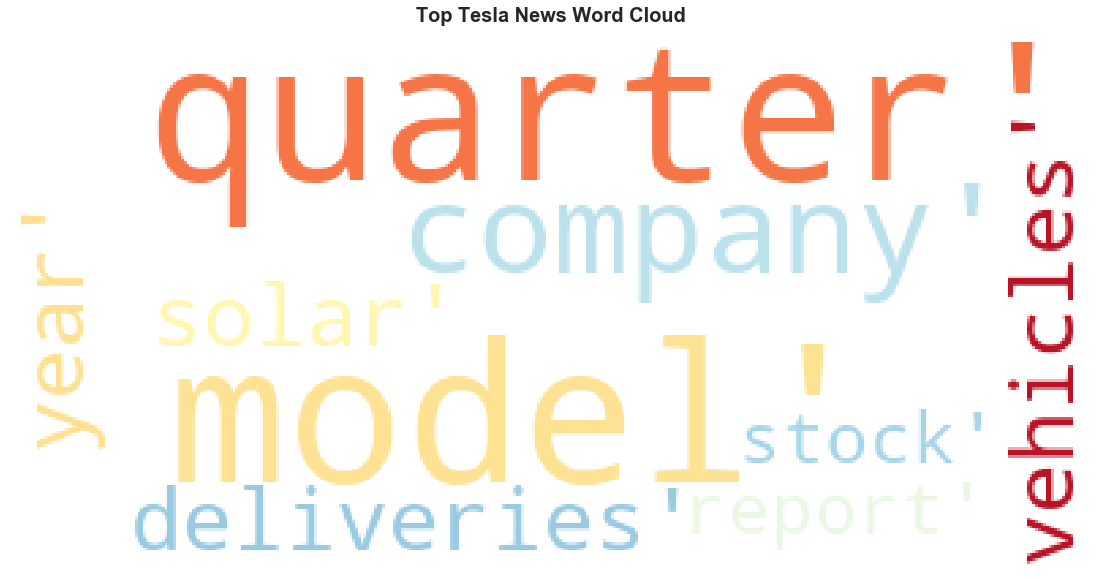

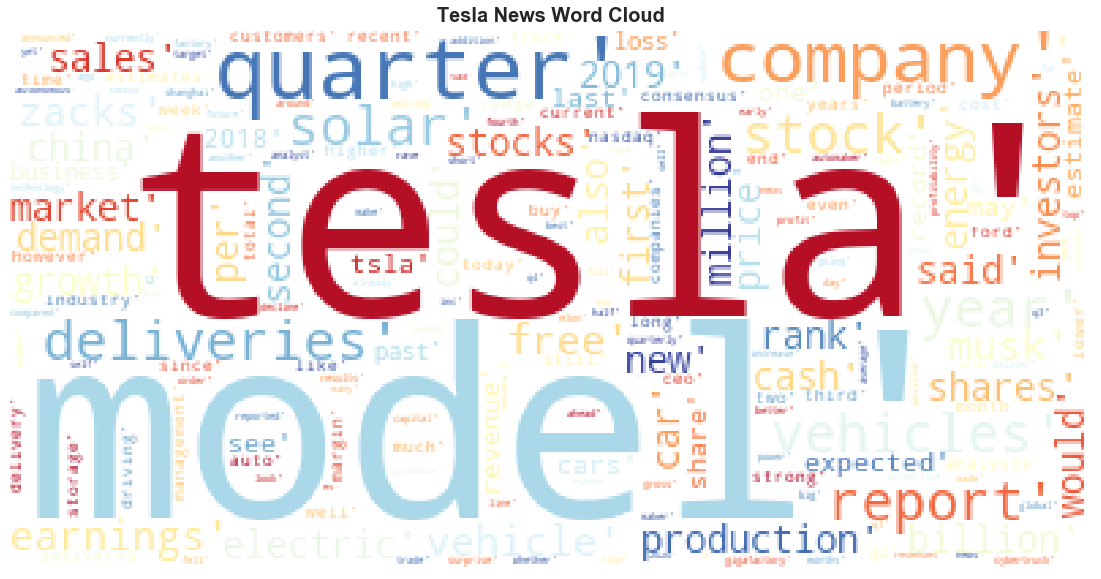

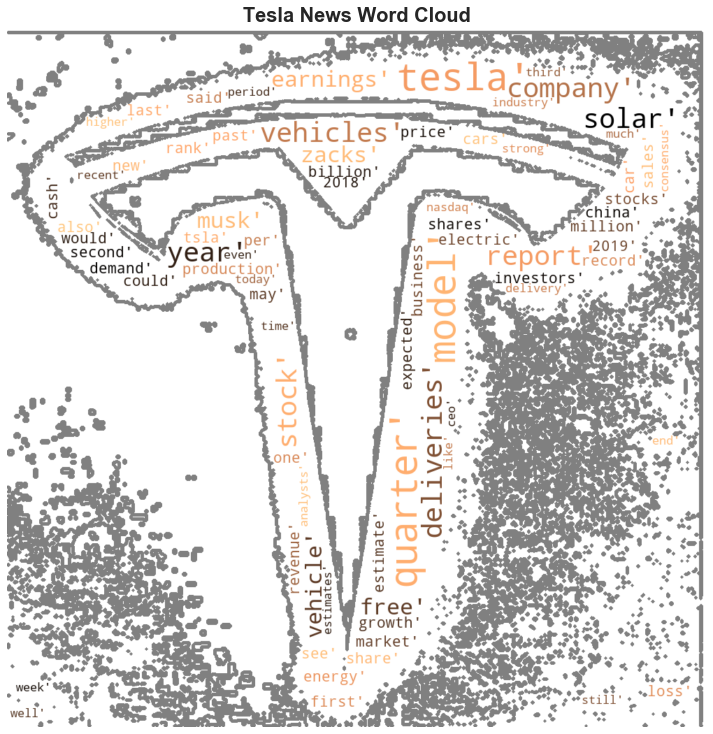

In [24]:
hroynlp.create_words_cloud_diagrams(df_for_regression['full_text'])

In [25]:
### Read in Vader, textblob lemmatized sentiments, textblob stemmed sentiments data for the news articlesand create the final dataframe to run regression on.
df_vader_sentiments = pd.read_csv('./data/vader_sentiments.csv',usecols=['Compound'])
df_for_regression["vader_sentiment"] =  list(df_vader_sentiments["Compound"])

df_textblob_lemmatized_sentiments = pd.read_csv('./data/textblob_lemmatized_sentiments.csv',usecols=['full_text'])
df_for_regression["textblob_lemmatized_sentiments"] = list(df_textblob_lemmatized_sentiments["full_text"])

df_textblob_stemmed_sentiments = pd.read_csv('./data/textblob_stemmed_sentiments.csv',usecols=['full_text'])
df_for_regression["textblob_stemmed_sentiments"] = list(df_textblob_stemmed_sentiments["full_text"])

In [26]:
df_for_regression.head(3)

,date,title,text,full_text,source_name,stocknews_sentiment,ticker,vader_sentiment,textblob_lemmatized_sentiments,textblob_stemmed_sentiments
0,2019-12-31,Why the Stock Market Soured on Tesla and Centu...,The carmaker's CEO had some Boring news to rep...,Many of us are preparing for the new year and ...,The Motley Fool,-1,TSLA,0.9109,0.087333,0.112693
1,2019-12-30,Tesla to Start Delivery of Model 3 Built at Ch...,The construction of Gigafactory3 in Shanghai i...,"Tesla, Inc. (TSLA - Free Report) will start de...",Zacks Investment Research,0,TSLA,0.9961,0.028692,-0.029774
2,2019-12-30,Tesla (TSLA) Rolls Out First Model 3s Built in...,Tesla Motors (TSLA) remains near the peak of i...,"Monday, December 30, 2019\nAdvance Trade in U....",Zacks Investment Research,1,TSLA,-0.8271,0.078244,0.099321


In [28]:
# set appropraite data type for date column and set it as index
df_for_regression=df_for_regression.astype({'date': 'datetime64[ns]'})
df_for_regression.set_index("date", inplace=True)

In [29]:
# sort by date
df_for_regression=df_for_regression.sort_values("date", ascending=True)
df_for_regression.head(4)

,title,text,full_text,source_name,stocknews_sentiment,ticker,vader_sentiment,textblob_lemmatized_sentiments,textblob_stemmed_sentiments
date,,,,,,,,,
2019-03-06,Did Audi Just Disrupt Tesla's Model Y?,Audi's e-tron Q4 Concept is aimed squarely at ...,Audi AG (OTC:AUDV.F) took the wraps off its la...,The Motley Fool,0,TSLA,0.9726,0.069364,0.041566
2019-03-08,Tesla (TSLA) Inks Deal With China Lenders for ...,Tesla (TSLA) is likely to benefit from a wholl...,"Tesla, Inc. (TSLA - Free Report) has made the ...",Zacks Investment Research,1,TSLA,0.9928,0.056798,0.097043
2019-03-09,Is This the Final Nail in the Coffin for Tesla...,Elon Musk used to be the solar installer's big...,There were already signs that all was not well...,The Motley Fool,-1,TSLA,0.9965,0.127565,0.095899
2019-03-09,Tesla Has Some Problems,Reading between the lines of the Tesla news ci...,Join Motley Fool analysts Nick Sciple and John...,The Motley Fool,-1,TSLA,0.9999,0.115436,0.107687


### Create dataframe for regression grouped on date - Dataframe number1 to be fed to Regression model1 and join with Tesla Stock prices

In [32]:
df_for_regression_grouped_by_date=pd.DataFrame(df_for_regression.groupby(["date","ticker"]).mean())
df_for_regression_grouped_by_date.head(4)

,,stocknews_sentiment,vader_sentiment,textblob_lemmatized_sentiments,textblob_stemmed_sentiments
date,ticker,,,,
2019-03-06,TSLA,0.0,0.9726,0.069364,0.041566
2019-03-08,TSLA,1.0,0.9928,0.056798,0.097043
2019-03-09,TSLA,-1.0,0.9982,0.121500,0.101793
2019-03-11,TSLA,-1.0,-0.9235,0.063292,0.087270


In [33]:
# join tsla_df (stock prices) with df_for_regression
df_for_regression_grouped_by_date=df_for_regression_grouped_by_date.join(tsla_df, on="date")

In [35]:
# re-sort the columns and drop NaNs
df_for_regression_grouped_by_date= df_for_regression_grouped_by_date[['TSLA_close','TSLA_close_shifted_by_1','stocknews_sentiment', 'vader_sentiment','textblob_lemmatized_sentiments', 'textblob_stemmed_sentiments']]
df_for_regression_grouped_by_date=df_for_regression_grouped_by_date.dropna()

In [37]:
# save datframe to file
df_for_regression_grouped_by_date.to_csv('./data/df_for_regression_grouped_by_date.csv',  header=df_for_regression_grouped_by_date.columns)

### Create dataframe for regression grouped on date and source - Dataframe number2 to be fed to Regression model2 and join with Tesla Stock prices

In [39]:
df_for_regression_grouped_by_date_and_source=pd.DataFrame(df_for_regression.groupby(["date","ticker","source_name"]).mean())
df_for_regression_grouped_by_date_and_source.reset_index(inplace=True)
# Make source_name values little shorter
df_for_regression_grouped_by_date_and_source['source_name'] = df_for_regression_grouped_by_date_and_source['source_name'].replace(['The Motley Fool'],'Motley')
df_for_regression_grouped_by_date_and_source['source_name'] = df_for_regression_grouped_by_date_and_source['source_name'].replace(['Zacks Investment Research'],'Zacks')
df_for_regression_grouped_by_date_and_source.head(3)

,date,ticker,source_name,stocknews_sentiment,vader_sentiment,textblob_lemmatized_sentiments,textblob_stemmed_sentiments
0,2019-03-06,TSLA,Motley,0.0,0.9726,0.069364,0.041566
1,2019-03-08,TSLA,Zacks,1.0,0.9928,0.056798,0.097043
2,2019-03-09,TSLA,Motley,-1.0,0.9982,0.121500,0.101793


####  Create temp dataframes for Motley and Zacks. Rename coulmns to respective names and merge again. The final dateframe should have columns as given below
### -->
     'ticker','zacks_stocknews_sentiment', 'zacks_vader_sentiment',
       'zacks_textblob_lemmatized_sentiments',
       'zacks_textblob_stemmed_sentiments', 'motley_stocknews_sentiment',
       'motley_vader_sentiment', 'motley_textblob_lemmatized_sentiments',
       'motley_textblob_stemmed_sentiments' ]

In [41]:
# create Motley dataframe
df_for_regression_grouped_by_date_and_source_motley=df_for_regression_grouped_by_date_and_source[df_for_regression_grouped_by_date_and_source.source_name =="Motley"]
df_for_regression_grouped_by_date_and_source_motley = df_for_regression_grouped_by_date_and_source_motley.drop('source_name', 1)
df_for_regression_grouped_by_date_and_source_motley = df_for_regression_grouped_by_date_and_source_motley.drop('ticker', 1)
df_for_regression_grouped_by_date_and_source_motley.columns = ['date', 'motley_stocknews_sentiment', 'motley_vader_sentiment',
       'motley_textblob_lemmatized_sentiments', 'motley_textblob_stemmed_sentiments']
df_for_regression_grouped_by_date_and_source_motley.head(2)

,date,motley_stocknews_sentiment,motley_vader_sentiment,motley_textblob_lemmatized_sentiments,motley_textblob_stemmed_sentiments
0,2019-03-06,0.0,0.9726,0.069364,0.041566
2,2019-03-09,-1.0,0.9982,0.121500,0.101793


In [42]:
# do the same for Zacks
df_for_regression_grouped_by_date_and_source_zacks=df_for_regression_grouped_by_date_and_source[df_for_regression_grouped_by_date_and_source.source_name =="Zacks"]
df_for_regression_grouped_by_date_and_source_zacks = df_for_regression_grouped_by_date_and_source_zacks.drop('source_name', 1)
df_for_regression_grouped_by_date_and_source_zacks = df_for_regression_grouped_by_date_and_source_zacks.drop('ticker', 1)
df_for_regression_grouped_by_date_and_source_zacks.columns = ['date',  'zacks_stocknews_sentiment', 'zacks_vader_sentiment',
       'zacks_textblob_lemmatized_sentiments', 'zacks_textblob_stemmed_sentiments']
df_for_regression_grouped_by_date_and_source_zacks.head(2)

,date,zacks_stocknews_sentiment,zacks_vader_sentiment,zacks_textblob_lemmatized_sentiments,zacks_textblob_stemmed_sentiments
1,2019-03-08,1.0,0.9928,0.056798,0.097043
16,2019-04-02,-1.0,0.9967,-0.069765,-0.154898


In [43]:
# Set indexes on the above data frames and merge them.
df_for_regression_grouped_by_date_and_source_motley.set_index("date", inplace=True)
df_for_regression_grouped_by_date_and_source_zacks.set_index("date", inplace=True)
df_for_regression_grouped_by_date_and_source_transposed = df_for_regression_grouped_by_date_and_source_zacks.join(df_for_regression_grouped_by_date_and_source_motley,on="date")
df_for_regression_grouped_by_date_and_source_transposed.head(4)

,zacks_stocknews_sentiment,zacks_vader_sentiment,zacks_textblob_lemmatized_sentiments,zacks_textblob_stemmed_sentiments,motley_stocknews_sentiment,motley_vader_sentiment,motley_textblob_lemmatized_sentiments,motley_textblob_stemmed_sentiments
date,,,,,,,,
2019-03-08,1.000000,0.992800,0.056798,0.097043,NaN,NaN,NaN,NaN
2019-04-02,-1.000000,0.996700,-0.069765,-0.154898,0.000000,-0.6006,0.077399,0.06403
2019-04-04,-0.333333,-0.255867,0.025594,0.042549,-0.333333,0.1181,0.075108,0.11754
2019-04-08,0.000000,0.962700,0.042437,0.005014,NaN,NaN,NaN,NaN


In [44]:
# rename coulmns
df_for_regression_grouped_by_date_and_source_transposed["ticker"]="TSLA"
df_for_regression_grouped_by_date_and_source_transposed = df_for_regression_grouped_by_date_and_source_transposed[['ticker','zacks_stocknews_sentiment', 'zacks_vader_sentiment',
       'zacks_textblob_lemmatized_sentiments',
       'zacks_textblob_stemmed_sentiments', 'motley_stocknews_sentiment',
       'motley_vader_sentiment', 'motley_textblob_lemmatized_sentiments',
       'motley_textblob_stemmed_sentiments' ]]

In [47]:
df_for_regression_grouped_by_date_and_source_transposed.head(2)

,ticker,zacks_stocknews_sentiment,zacks_vader_sentiment,zacks_textblob_lemmatized_sentiments,zacks_textblob_stemmed_sentiments,motley_stocknews_sentiment,motley_vader_sentiment,motley_textblob_lemmatized_sentiments,motley_textblob_stemmed_sentiments
date,,,,,,,,,
2019-03-08,TSLA,1.0,0.9928,0.056798,0.097043,NaN,NaN,NaN,NaN
2019-04-02,TSLA,-1.0,0.9967,-0.069765,-0.154898,0.0,-0.6006,0.077399,0.06403


In [48]:
# join tsla_df (stock prices) with df_for_regression_grouped_by_date_and_source_transposed
df_for_regression_grouped_by_date_and_source_transposed=df_for_regression_grouped_by_date_and_source_transposed.join(tsla_df, on="date")
# re-sort the columns
df_for_regression_grouped_by_date_and_source_transposed= df_for_regression_grouped_by_date_and_source_transposed[['ticker', 'TSLA_close','TSLA_close_shifted_by_1','zacks_stocknews_sentiment', 'zacks_vader_sentiment',
       'zacks_textblob_lemmatized_sentiments',
       'zacks_textblob_stemmed_sentiments', 'motley_stocknews_sentiment',
       'motley_vader_sentiment', 'motley_textblob_lemmatized_sentiments',
       'motley_textblob_stemmed_sentiments']]
df_for_regression_grouped_by_date_and_source_transposed.head(4)

,ticker,TSLA_close,TSLA_close_shifted_by_1,zacks_stocknews_sentiment,zacks_vader_sentiment,zacks_textblob_lemmatized_sentiments,zacks_textblob_stemmed_sentiments,motley_stocknews_sentiment,motley_vader_sentiment,motley_textblob_lemmatized_sentiments,motley_textblob_stemmed_sentiments
date,,,,,,,,,,,
2019-03-08,TSLA,284.140015,276.589996,1.000000,0.992800,0.056798,0.097043,NaN,NaN,NaN,NaN
2019-04-02,TSLA,285.880005,289.179993,-1.000000,0.996700,-0.069765,-0.154898,0.000000,-0.6006,0.077399,0.06403
2019-04-04,TSLA,267.779999,291.809998,-0.333333,-0.255867,0.025594,0.042549,-0.333333,0.1181,0.075108,0.11754
2019-04-08,TSLA,273.200012,274.959991,0.000000,0.962700,0.042437,0.005014,NaN,NaN,NaN,NaN


In [49]:
# dropna and save dataframe
df_for_regression_grouped_by_date_and_source_transposed=df_for_regression_grouped_by_date_and_source_transposed.dropna()
df_for_regression_grouped_by_date_and_source_transposed.to_csv('./data/df_for_regression_grouped_by_date_and_source_transposed_without_NaN.csv',  header=df_for_regression_grouped_by_date_and_source_transposed.columns)

# Section4. Regression Analysis to determine the correlation.

#####     _df_for_regression_grouped_by_date_hysteresis.csv and df_for_regression_grouped_by_date_and_source_transposed_without_NaN_hysteresis.csv were created manually_
#####     _by merging stock data and output files from above section._

In [1]:
# Read in data from files created in section3
from pathlib import Path
import pandas as pd
file_name = './data/df_for_regression_grouped_by_date_hysteresis.csv'
# file_name = 'df_for_regression_grouped_by_date_and_source_transposed_without_NaN_hysteresis.csv'
# data = Path(f'Jatinder/files/data/{file_name}')
data = Path(f'{file_name}')
all_df = pd.read_csv(data)
sent_all_df=all_df.drop(columns=['date'])
all_df=all_df.set_index('date')
all_df.head()

,dly_rtn,stocknews_sentiment,vader_sentiment,textblob_lemmatized_sentiments,textblob_stemmed_sentiments
date,,,,,
3/6/19,-0.001085,0.0,0.9726,0.069364,0.041566
3/7/19,0.001267,0.5,0.9827,0.063081,0.069304
3/8/19,0.027297,1.0,0.9928,0.056798,0.097043
3/11/19,0.023861,-1.0,-0.9235,0.063292,0.087270
3/12/19,-0.025987,-1.0,-0.9229,0.022327,-0.032525


In [2]:
file_name = './data/df_for_regression_grouped_by_date_and_source_transposed_without_NaN_hysteresis.csv'
# data = Path(f'Jatinder/files/data/{file_name}')
data = Path(f'{file_name}')
news_df = pd.read_csv(data)
sent_news_df=news_df.drop(columns=['date'])
news_df=news_df.set_index('date')
news_df.head()

,dly_rtn,zacks_stocknews_sentiment,zacks_vader_sentiment,zacks_textblob_lemmatized_sentiments,zacks_textblob_stemmed_sentiments,motley_stocknews_sentiment,motley_vader_sentiment,motley_textblob_lemmatized_sentiments,motley_textblob_stemmed_sentiments
date,,,,,,,,,
4/2/19,-0.011412,-1.000000,0.996800,-0.069765,-0.154898,0.000000,-0.403700,0.077399,0.064030
4/3/19,0.020743,-0.666667,0.370467,-0.022086,-0.056175,-0.166667,-0.142800,0.076253,0.090785
4/4/19,-0.082348,-0.333333,-0.255867,0.025594,0.042549,-0.333333,0.118100,0.075108,0.117540
4/5/19,0.026813,-0.166667,0.177117,0.035486,0.041806,-0.666667,0.295625,0.057064,0.086493
4/8/19,-0.006401,-0.166667,0.177117,0.035486,0.041806,-0.666667,0.295625,0.057064,0.086493


### Monte_Carlo Option 1
#### Lasso Regression
#### https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

In [3]:
# input dataframe with at least 2 columns: 
## first column: daily closing price
## second+ column: daily sentiment analysis
# input number of iterations (days to shift sentiment analysis)
#
# output:
## Feature: column name of best feature
## coef: coef of best feature
## days_shift: number of days shifted for best correlation

def sent_monte_carlo_1 (df, iterations, alpha_in):
    #Instantiate libraries
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Lasso
    import numpy as np
 
    
    #Create empty list to store coefficients
    coef_list = []
    #Create empty list to store max features
    feat_list = []
 
    #Seperate the Features (X) from the Target (y)
    target_name=df.columns[0]
    y=df[target_name]
    X=df.drop(columns=target_name)
    
    for x in range(0, iterations):
        #Split data into training and testing data
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.3,
                                                            random_state=31)
                
        #Scale the data as linear models
        scaler = StandardScaler()
        scaler.fit(X_train.fillna(0))

        #Run Lasso Regression 
        lasso_model = Lasso(alpha=alpha_in, normalize=True)
        lasso_model.fit(X_train,y_train)
        train_score=lasso_model.score(X_train,y_train)
        test_score=lasso_model.score(X_test,y_test)
        lasso_coef = np.sum(lasso_model.coef_!=0)      
        
        #Store features that were selected
        num_selected_feat = lasso_coef
        num_total_feat = X_train.shape[1]
        
        #if no featuers were selected, append error values to coef_list and feat_list
        #else, append max coefficient and column name for best coefficient
        if (num_selected_feat == 0):
            print(f'No features selected for days shift {x}')
            #Append error max coefficient
            coef_list.append(-999)
            #Append error column name to feature list
            feat_list.append(-999)
        else:
            #Calculate and append max coefficient
            coef_list.append(max(lasso_model.coef_))
            #Grab index of max coefficient
            indx=np.argmax(lasso_model.coef_)
            #Append column name to feature list
            feat_list.append(X.columns[indx])

        #Shift features by 1 day
        hysteresis=X[:1]
        X=X.shift(1)
        X[:1]=hysteresis

    #save max coefficient from monte carlo
    coef_max=max(coef_list) 
    #save index of max coefficient...this is equal to the number of days shifted
    days_shift=np.argmax(coef_list)
    #grab column name of feature with the best overall max coefficient
    feature =feat_list[days_shift]
    
    print(f'Monte Carlo Sentiment Analysis Results:')
    print(f'Number of iterations:        {iterations}')
    print(f'Number of selected features: {num_selected_feat}')
    print(f'Best feature:                {feature}')
    print(f'Best coefficient:            {coef_max}')
    print(f'Days Shifted:                {days_shift}')
    
    return feature, coef_max, days_shift, coef_list, feat_list

In [4]:
f, c_m, s, c_l, f_l = sent_monte_carlo_1(sent_all_df, 20, .00000000001)

Monte Carlo Sentiment Analysis Results:
Number of iterations:        20
Number of selected features: 4
Best feature:                textblob_lemmatized_sentiments
Best coefficient:            0.13970649844802163
Days Shifted:                0


### Monte_Carlo Option 2
####Lasso Regression using LogisticRegression Model
#### https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

In [5]:
# input dataframe with at least 2 columns: 
## first column: daily closing price
## second+ column: daily sentiment analysis
# input number of iterations (days to shift sentiment analysis)
#
# output:
## Feature: column name of best feature
## coef: coef of best feature
## days_shift: number of days shifted for best correlation

def sent_monte_carlo_2 (df, iterations, solver_in):
    #Instantiate libraries
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Lasso, LogisticRegression
    from sklearn.feature_selection import SelectFromModel
    import numpy as np  
    
    #Create empty list to store coefficients
    coef_list = []
    #Create empty list to store max features
    feat_list = []

    #Seperate the Features (X) from the Target (y)
    target_name=df.columns[0]
    y=df[target_name]
    X=df.drop(columns=target_name)
    
    for x in range(0, iterations):
        #Split data into training and testing data
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.3,
                                                            random_state=0)
                
        #Scale the data as linear models
        scaler = StandardScaler()
        scaler.fit(X_train.fillna(0))

        #Run Lasso Regression (LogisticRegression using Lasso (L1) penatly)
        #Select features using the selectFromModel
        lasso_model = LogisticRegression(C=1, class_weight=None, dual=False,
                                         fit_intercept=True, intercept_scaling=1,
                                         max_iter=100, multi_class='ovr', n_jobs=1,
                                         penalty='l1', random_state=None, solver=solver_in, 
                                         tol=0.0001, verbose=0, warm_start=False)
        sel_=SelectFromModel(estimator=lasso_model, prefit=False, threshold=None)
        
        #Convert y_train into a category by representing day-to-day return increases as 1 and decreases as 0
        y_train_shift=y_train.shift(1)
        y_train_shift[:1]=0
        y_train_cat=np.where(y_train_shift>y_train,0,1)
        
        #Fit the model
        sel_.fit(scaler.transform(X_train.fillna(0)), y_train_cat)         
        
        #Store features that were selected
        selected_feat = X_train.columns[(sel_.get_support())]
        num_selected_feat = len(selected_feat)
        num_total_feat = X_train.shape[1]
        
        #if no featuers were selected, append error values to coef_list and feat_list
        #else, append max coefficient and column name for best coefficient
        if (num_selected_feat == 0):
            print(f'No features selected for days shift {x}')
            #Append error max coefficient
            coef_list.append(-999)
            #Append error column name to feature list
            feat_list.append(-999)
        else:
            #Grab coefficient per feature
            lasso_coef = sel_.estimator_.coef_
            #Calculate and append max coefficient
            coef_list.append(max(lasso_coef[0]))
            #Grab index of max coefficient
            indx=np.argmax(lasso_coef)
            #Append column name to feature list
            feat_list.append(X.columns[indx])

        #Shift features by 1 day
        hysteresis=X[:1]
        X=X.shift(1)
        X[:1]=hysteresis

    #save max coefficient from monte carlo
    coef_max=max(coef_list) 
    #save index of max coefficient...this is equal to the number of days shifted
    days_shift=np.argmax(coef_list)
    #grab column name of feature with the best overall max coefficient
    feature =feat_list[days_shift]
    
    print(f'Monte Carlo Sentiment Analysis Results:')
    print(f'Number of iterations:        {iterations}')
    print(f'Number of selected features: {num_selected_feat}')
    print(f'Best feature:                {feature}')
    print(f'Best coefficient:            {coef_max}')
    print(f'Days Shifted:                {days_shift}')
    
    return feature, coef_max, days_shift, coef_list, feat_list

## Analysis

In [7]:
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
import panel as pn
from panel.interact import interact
from panel import widgets
import numpy as np

from scipy.optimize import minimize

%matplotlib inline

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

### _a) Model 1 with All Sentiments_

In [8]:
#Run Model 1 with All Sentiments
f, c_m, s, c_l, f_l = sent_monte_carlo_1(sent_all_df, 20, .0001)

Monte Carlo Sentiment Analysis Results:
Number of iterations:        20
Number of selected features: 1
Best feature:                textblob_lemmatized_sentiments
Best coefficient:            0.0862973522388975
Days Shifted:                0


In [9]:
winner=all_df[f].shift(s)
all_df[f+'_shifted_'+str(s)+'_days']=pd.DataFrame(winner)
all_df.head()

,dly_rtn,stocknews_sentiment,vader_sentiment,textblob_lemmatized_sentiments,textblob_stemmed_sentiments,textblob_lemmatized_sentiments_shifted_0_days
date,,,,,,
3/6/19,-0.001085,0.0,0.9726,0.069364,0.041566,0.069364
3/7/19,0.001267,0.5,0.9827,0.063081,0.069304,0.063081
3/8/19,0.027297,1.0,0.9928,0.056798,0.097043,0.056798
3/11/19,0.023861,-1.0,-0.9235,0.063292,0.087270,0.063292
3/12/19,-0.025987,-1.0,-0.9229,0.022327,-0.032525,0.022327


In [10]:
# Plot the daily returns and best feature
all_df.hvplot.line(
    x="date",
    xlabel="Closing Date",
    y=["dly_rtn", f+'_shifted_'+str(s)+'_days'],
    rot=90,
    width=800,
    height=600).opts(
        title="Model 1: Winner of All Sentiments",
        legend_position='bottom')

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [11]:
monte=pd.DataFrame([f_l,c_l]).T
monte=monte.rename(columns={0: 'Winning Feature', 1: 'Max Coeff'})
monte.head()

,Winning Feature,Max Coeff
0,textblob_lemmatized_sentiments,0.0862974
1,stocknews_sentiment,0.00738255
2,stocknews_sentiment,0.00275746
3,stocknews_sentiment,0.00534635
4,stocknews_sentiment,0.00295196


In [12]:
# Plot the coefficients
import matplotlib.pyplot as plt
monte.hvplot(
#     x=index,
    xlabel='Monte Carlo Iteration',
    y='Max Coeff',
    by='Winning Feature',
    kind='scatter',
    width=800,
    height=400
).opts(
        title="Model 1: All Sentiments Winner per Iteration"
)

:NdOverlay   [Winning Feature]
   :Scatter   [index]   (Max Coeff)

### _b) Model 2 with All Sentiments_

In [13]:
#Run Model 2 with All Sentiments
f, c_m, s, c_l, f_l = sent_monte_carlo_2(sent_all_df, 20, 'liblinear')

Monte Carlo Sentiment Analysis Results:
Number of iterations:        20
Number of selected features: 3
Best feature:                textblob_lemmatized_sentiments
Best coefficient:            0.4566238603227083
Days Shifted:                0


In [14]:
winner=all_df[f].shift(s)
all_df[f+'_shifted_'+str(s)+'_days']=pd.DataFrame(winner)
all_df.head()

,dly_rtn,stocknews_sentiment,vader_sentiment,textblob_lemmatized_sentiments,textblob_stemmed_sentiments,textblob_lemmatized_sentiments_shifted_0_days
date,,,,,,
3/6/19,-0.001085,0.0,0.9726,0.069364,0.041566,0.069364
3/7/19,0.001267,0.5,0.9827,0.063081,0.069304,0.063081
3/8/19,0.027297,1.0,0.9928,0.056798,0.097043,0.056798
3/11/19,0.023861,-1.0,-0.9235,0.063292,0.087270,0.063292
3/12/19,-0.025987,-1.0,-0.9229,0.022327,-0.032525,0.022327


In [15]:
# Plot the daily returns and best feature
all_df.hvplot.line(
    x="date",
    xlabel="Closing Date",
    y=["dly_rtn", f+'_shifted_'+str(s)+'_days'],
    rot=90,
    width=800,
    height=600).opts(
        title="Model 2: Winner of All Sentiments",
        legend_position='bottom')

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [16]:
monte=pd.DataFrame([f_l,c_l]).T
monte=monte.rename(columns={0: 'Winning Feature', 1: 'Max Coeff'})
monte.head()

,Winning Feature,Max Coeff
0,textblob_lemmatized_sentiments,0.456624
1,stocknews_sentiment,0.176301
2,stocknews_sentiment,0.175708
3,textblob_lemmatized_sentiments,0.134826
4,stocknews_sentiment,0.185776


In [17]:
# Plot the coefficients
import matplotlib.pyplot as plt
monte.hvplot(
#     x=index,
    xlabel='Monte Carlo Iteration',
    y='Max Coeff',
    by='Winning Feature',
    kind='scatter',
    width=800,
    height=400
).opts(
        title="Model 2: All Sentiments Winner per Iterationn"
)

:NdOverlay   [Winning Feature]
   :Scatter   [index]   (Max Coeff)

### _c) Model 1 with Sentiments by News Source_

In [19]:
#Run Model 1 with Sentiments by News Source
f, c_m, s, c_l, f_l = sent_monte_carlo_1(sent_news_df, 20, .0001)

Monte Carlo Sentiment Analysis Results:
Number of iterations:        20
Number of selected features: 2
Best feature:                motley_textblob_stemmed_sentiments
Best coefficient:            0.11184922854812286
Days Shifted:                0


In [20]:
winner=news_df[f].shift(s)
news_df[f+'_shifted_'+str(s)+'_days']=pd.DataFrame(winner)
news_df.head()

,dly_rtn,zacks_stocknews_sentiment,zacks_vader_sentiment,zacks_textblob_lemmatized_sentiments,zacks_textblob_stemmed_sentiments,motley_stocknews_sentiment,motley_vader_sentiment,motley_textblob_lemmatized_sentiments,motley_textblob_stemmed_sentiments,motley_textblob_stemmed_sentiments_shifted_0_days
date,,,,,,,,,,
4/2/19,-0.011412,-1.000000,0.996800,-0.069765,-0.154898,0.000000,-0.403700,0.077399,0.064030,0.064030
4/3/19,0.020743,-0.666667,0.370467,-0.022086,-0.056175,-0.166667,-0.142800,0.076253,0.090785,0.090785
4/4/19,-0.082348,-0.333333,-0.255867,0.025594,0.042549,-0.333333,0.118100,0.075108,0.117540,0.117540
4/5/19,0.026813,-0.166667,0.177117,0.035486,0.041806,-0.666667,0.295625,0.057064,0.086493,0.086493
4/8/19,-0.006401,-0.166667,0.177117,0.035486,0.041806,-0.666667,0.295625,0.057064,0.086493,0.086493


In [21]:
# Plot the daily returns and best feature
news_df.hvplot.line(
    x="date",
    xlabel="Closing Date",
    y=["dly_rtn", f+'_shifted_'+str(s)+'_days'],
    rot=90,
    width=800,
    height=600).opts(
        title="Model 1: Winner of Sentiments by News Source",
        legend_position='bottom')

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [22]:
target_name=sent_news_df.columns[0]
y=sent_news_df[target_name]
X=sent_news_df.drop(columns=target_name)
# news_source=pn.widgets.Select(name='News Source', options=X.columns.values.tolist())
news_df.hvplot.line(
    xlabel="Closing Date",
#     groupby=X.columns.values.tolist(),
    rot=90,
    width=800,
    height=600).opts(
        title="Model 1: Sentiments by News Source",
        legend_position='bottom')
# pn.Row(news_source, plot)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [23]:
monte=pd.DataFrame([f_l,c_l]).T
monte=monte.rename(columns={0: 'Winning Feature', 1: 'Max Coeff'})
monte.head()

,Winning Feature,Max Coeff
0,motley_textblob_stemmed_sentiments,0.111849
1,motley_textblob_stemmed_sentiments,0.0845968
2,motley_textblob_stemmed_sentiments,0.0347357
3,motley_textblob_stemmed_sentiments,0.0297031
4,motley_textblob_lemmatized_sentiments,0.0494428


In [24]:
# Plot the coefficients
import matplotlib.pyplot as plt
monte.hvplot(
#     x=index,
    xlabel='Monte Carlo Iteration',
    y='Max Coeff',
    by='Winning Feature',
    kind='scatter',
    width=800,
    height=400
).opts(
        title="Model 1: Sentiments by News Source Winner per Iteration"
)

:NdOverlay   [Winning Feature]
   :Scatter   [index]   (Max Coeff)

### _d) Model 2 with Sentiments by News Source_

In [26]:
#Run Model 2 with Sentiments by News Source
f, c_m, s, c_l, f_l = sent_monte_carlo_2(sent_news_df, 20, 'liblinear')

Monte Carlo Sentiment Analysis Results:
Number of iterations:        20
Number of selected features: 7
Best feature:                zacks_stocknews_sentiment
Best coefficient:            0.5765328899413446
Days Shifted:                1


In [27]:
winner=news_df[f].shift(s)
news_df[f+'_shifted_'+str(s)+'_days']=pd.DataFrame(winner)
news_df.head()

,dly_rtn,zacks_stocknews_sentiment,zacks_vader_sentiment,zacks_textblob_lemmatized_sentiments,zacks_textblob_stemmed_sentiments,motley_stocknews_sentiment,motley_vader_sentiment,motley_textblob_lemmatized_sentiments,motley_textblob_stemmed_sentiments,motley_textblob_stemmed_sentiments_shifted_0_days,zacks_stocknews_sentiment_shifted_1_days
date,,,,,,,,,,,
4/2/19,-0.011412,-1.000000,0.996800,-0.069765,-0.154898,0.000000,-0.403700,0.077399,0.064030,0.064030,NaN
4/3/19,0.020743,-0.666667,0.370467,-0.022086,-0.056175,-0.166667,-0.142800,0.076253,0.090785,0.090785,-1.000000
4/4/19,-0.082348,-0.333333,-0.255867,0.025594,0.042549,-0.333333,0.118100,0.075108,0.117540,0.117540,-0.666667
4/5/19,0.026813,-0.166667,0.177117,0.035486,0.041806,-0.666667,0.295625,0.057064,0.086493,0.086493,-0.333333
4/8/19,-0.006401,-0.166667,0.177117,0.035486,0.041806,-0.666667,0.295625,0.057064,0.086493,0.086493,-0.166667


In [28]:
# Plot the daily returns and best feature
news_df.hvplot.line(
    x="date",
    xlabel="Closing Date",
    y=["dly_rtn", f+'_shifted_'+str(s)+'_days'],
    rot=90,
    width=800,
    height=600).opts(
        title="Model 2: Winner of Sentiments by News Source",
        legend_position='bottom')

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [29]:
monte=pd.DataFrame([f_l,c_l]).T
monte=monte.rename(columns={0: 'Winning Feature', 1: 'Max Coeff'})
monte.head()

,Winning Feature,Max Coeff
0,zacks_stocknews_sentiment,0.429301
1,zacks_stocknews_sentiment,0.576533
2,motley_textblob_stemmed_sentiments,0.367949
3,zacks_stocknews_sentiment,0.257826
4,zacks_vader_sentiment,0.179269


In [30]:
# Plot the coefficients
import matplotlib.pyplot as plt
monte.hvplot(
#     x=index,
    xlabel='Monte Carlo Iteration',
    y='Max Coeff',
    by='Winning Feature',
    kind='scatter',
    width=800,
    height=400
).opts(
        title="Model 2: Sentiments by News Source Winner per Iteration"
)

:NdOverlay   [Winning Feature]
   :Scatter   [index]   (Max Coeff)